### Plots for Comparision of Different methods with and without Short Selling

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cm as cm
import numpy as np
from skfolio.moments import EmpiricalCovariance

In [2]:
oos_ss = pd.read_csv("oos_returns_SS.csv", index_col=0, parse_dates=True)
oos_nss = pd.read_csv("oos_returns_NSS.csv", index_col=0, parse_dates=True)

/var/folders/ng/4mdk7q7d2hschz1nhvq8_vmm0000gn/T/ipykernel_90466/3750980359.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors_ss = cm.get_cmap('Dark2', len(methods))
/var/folders/ng/4mdk7q7d2hschz1nhvq8_vmm0000gn/T/ipykernel_90466/3750980359.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors_nss = cm.get_cmap('Set1', len(methods))


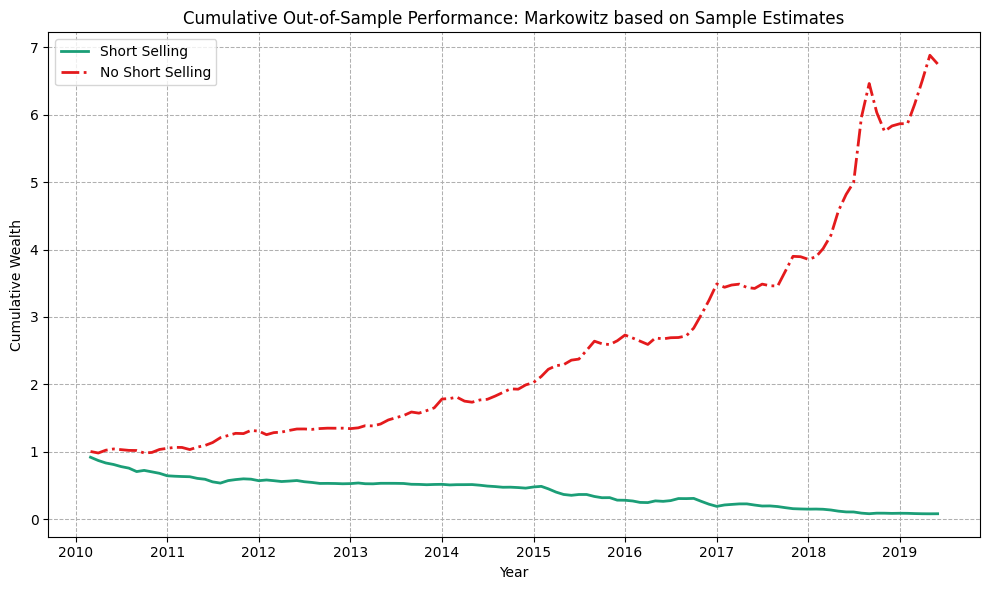

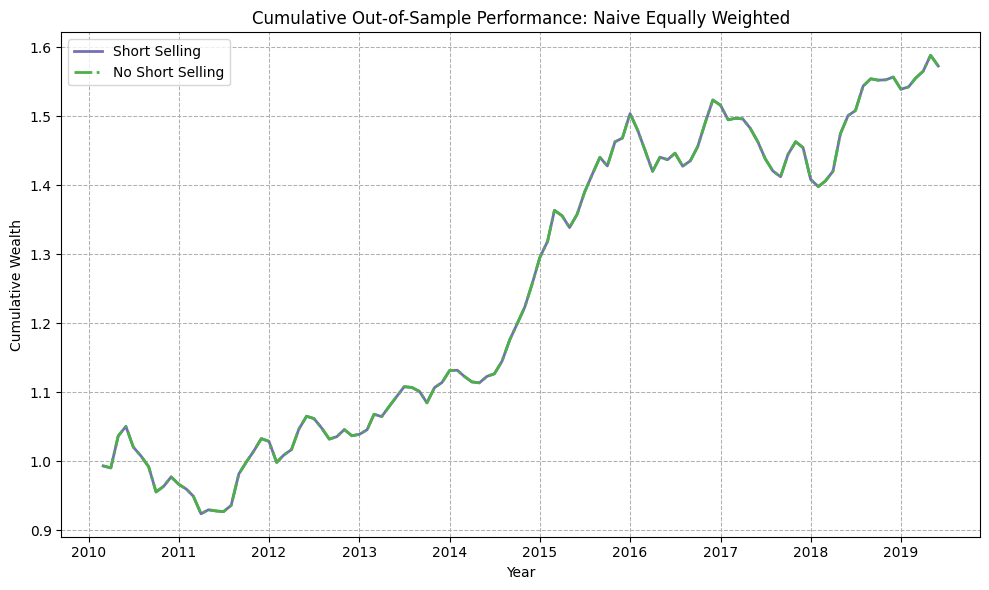

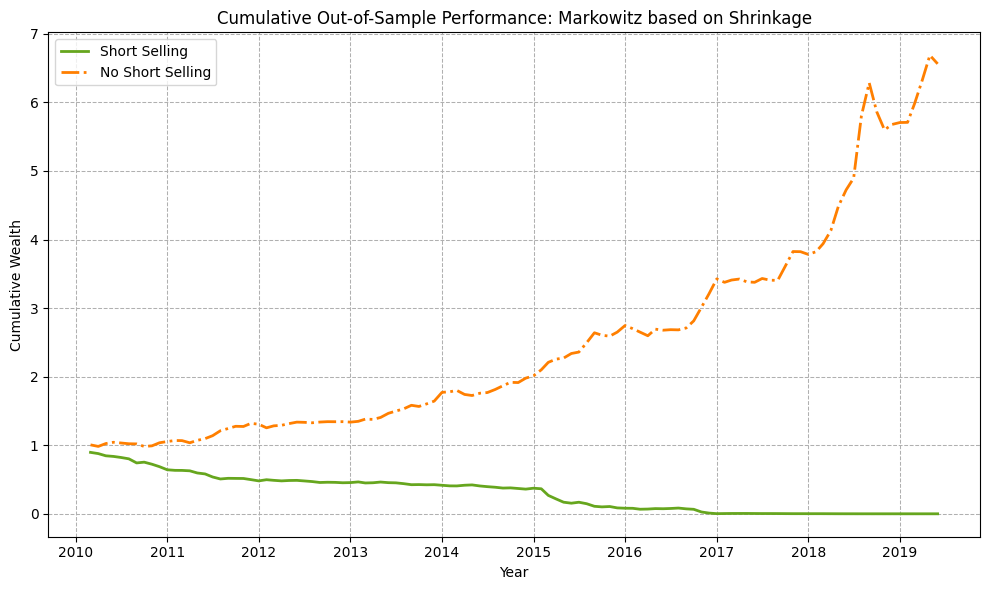

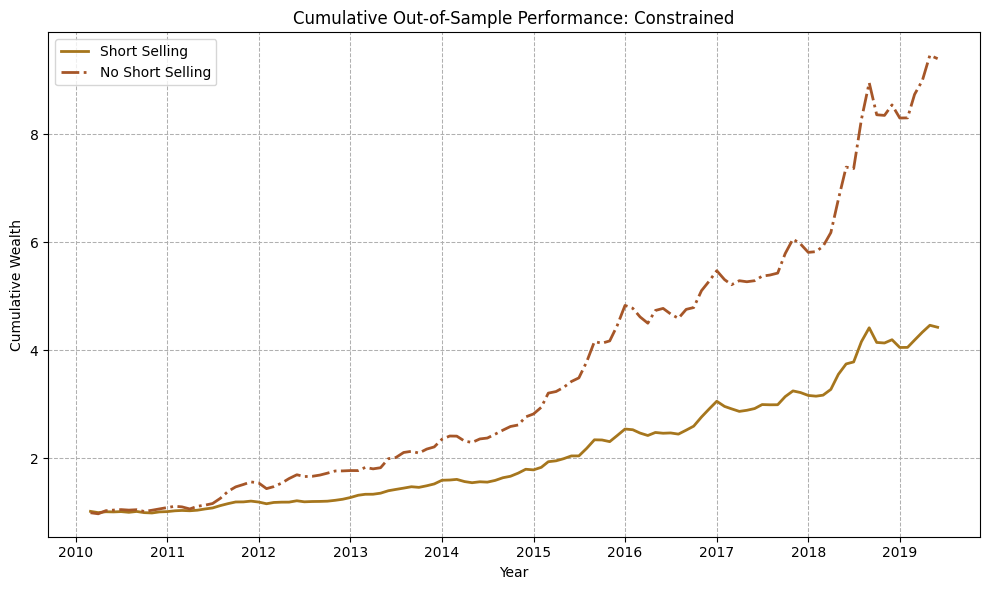

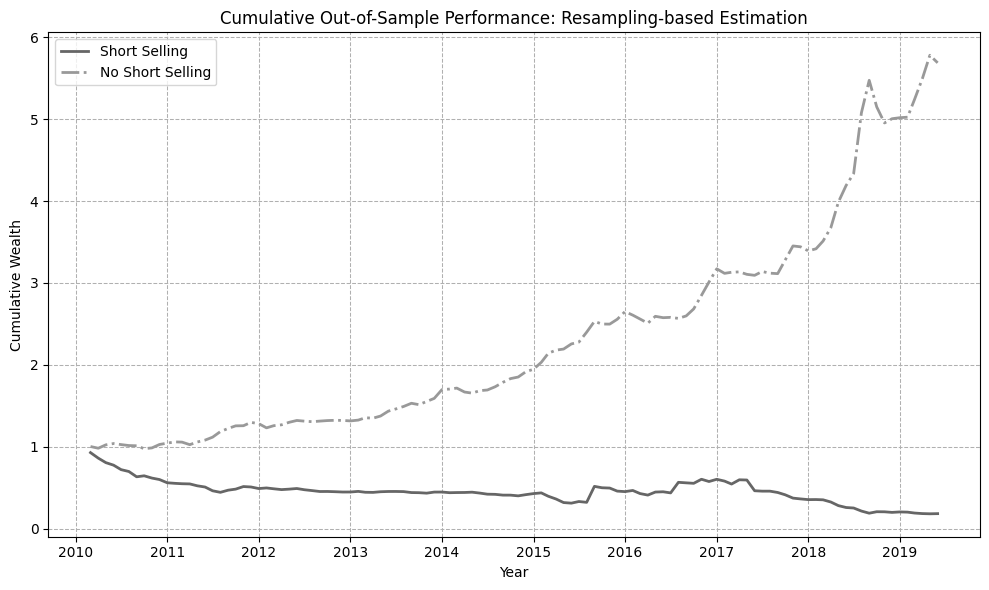

In [ ]:
cum_returns_ss = (1 + oos_ss).cumprod()
cum_returns_nss = (1 + oos_nss).cumprod()

methods = cum_returns_ss.columns
colors_ss = cm.get_cmap('Dark2', len(methods))
colors_nss = cm.get_cmap('Set1', len(methods))

for i, method in enumerate(methods):
    plt.figure(figsize=(10, 6))
    
    ss_color = colors_ss(i)
    nss_color = colors_nss(i)
    
    plt.plot(cum_returns_ss.index, cum_returns_ss[method], label=f"Short Selling",
             color=ss_color, linewidth=2)
    plt.plot(cum_returns_nss.index, cum_returns_nss[method], label=f"No Short Selling",
             color=nss_color, linewidth=2, linestyle='dashdot')
    plt.legend()
    plt.title(f"Cumulative Out-of-Sample Performance: {method}")
    plt.xlabel("Year")
    plt.ylabel("Cumulative Wealth")
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.grid(True, linestyle='--', linewidth=0.75)
    plt.tight_layout()
    plt.savefig(f"{method}_cum_comparision.png", dpi=300, bbox_inches="tight")
    plt.show()
    plt.close()

#### Tangency Plots

/var/folders/ng/4mdk7q7d2hschz1nhvq8_vmm0000gn/T/ipykernel_90466/1194499737.py:49: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors_ss = cm.get_cmap('Set1', len(methods))
/var/folders/ng/4mdk7q7d2hschz1nhvq8_vmm0000gn/T/ipykernel_90466/1194499737.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors_nss = cm.get_cmap('plasma', len(methods))


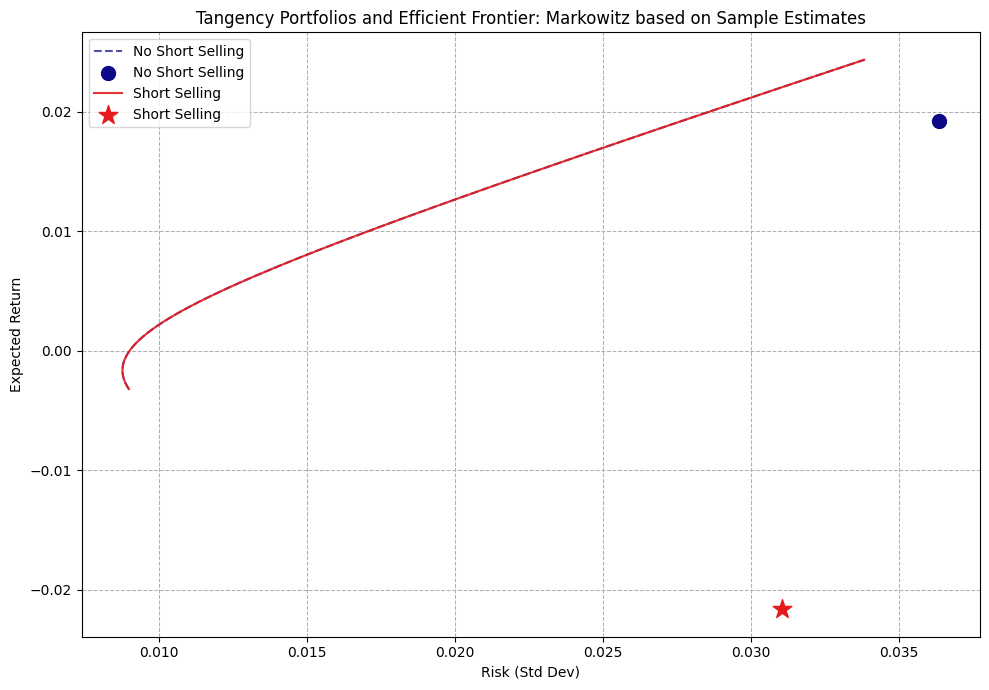

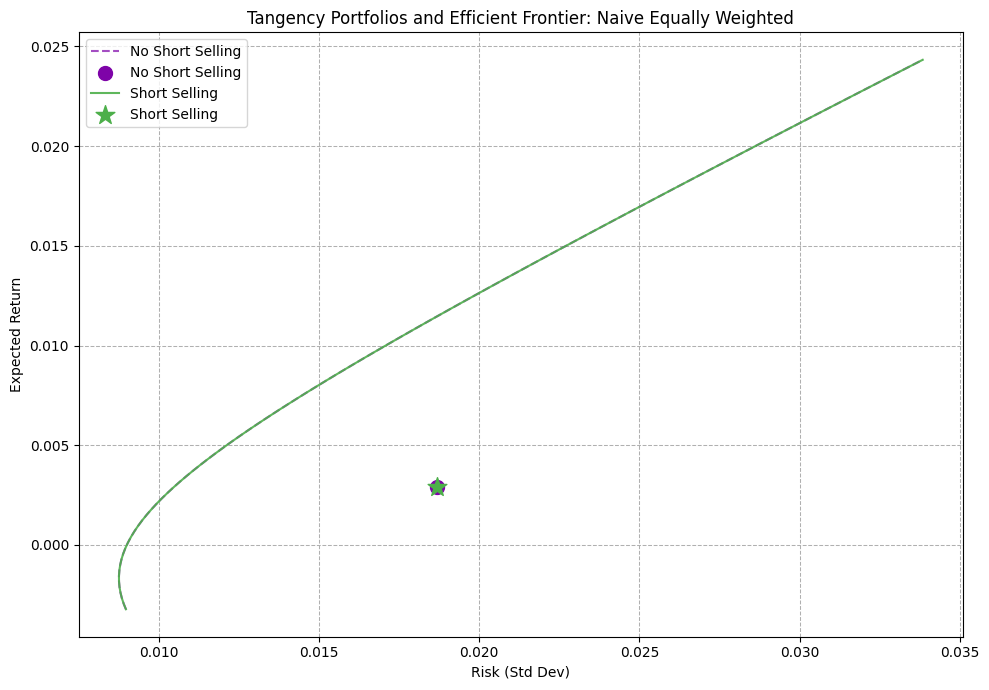

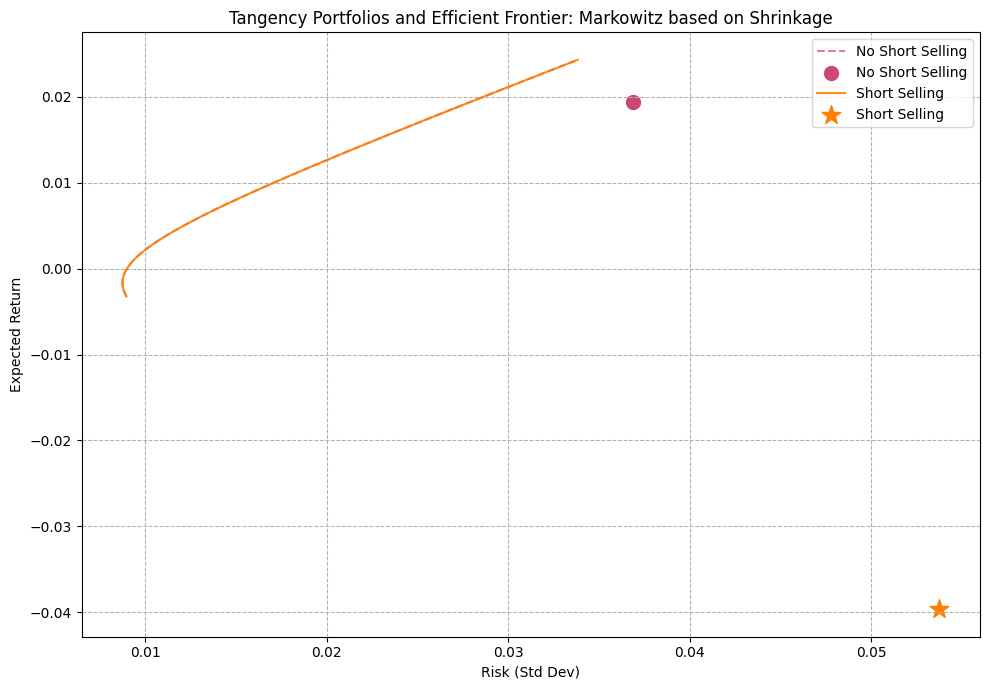

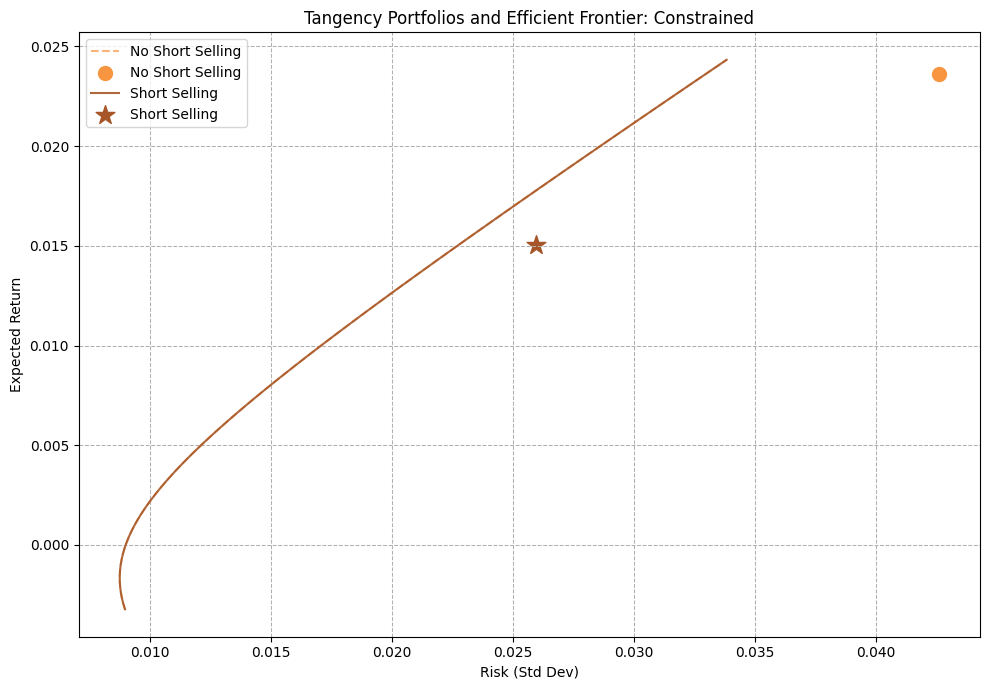

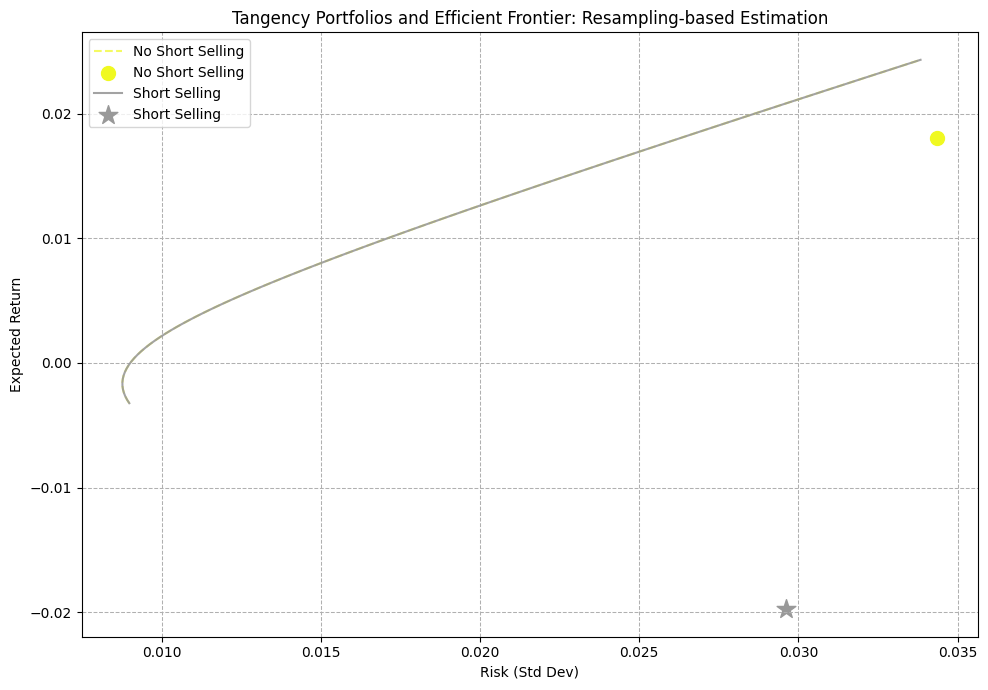

In [ ]:
asset_returns = pd.read_csv("FX_excess_returns.csv", index_col=0, parse_dates=True)

methods = [
    "Markowitz based on Sample Estimates",
    "Naive Equally Weighted",
    "Markowitz based on Shrinkage",
    "Constrained",
    "Resampling-based Estimation"
]
weights_nss = {m: pd.read_csv(f"{m}_weights_NSS.csv", index_col=0) for m in methods}
weights_ss = {m: pd.read_csv(f"{m}_weights_SS.csv", index_col=0) for m in methods}

def portfolio_performance(returns, weights, risk_free_rate=0.0):
    port_returns = returns.dot(weights)
    mean_return = port_returns.mean()
    risk = port_returns.std()
    sharpe = (mean_return - risk_free_rate) / risk
    return port_returns, mean_return, risk, sharpe

def analytical_frontier(returns):
    assets = returns.columns
    n_assets = len(assets)

    mu_hat = returns.mean().values
    Sigma_hat = EmpiricalCovariance().fit(returns.values).covariance_
    inv_Sigma = np.linalg.inv(Sigma_hat)
    ones = np.ones(n_assets)

    # Tangency portfolio (risk-free = 0)
    w_tan = inv_Sigma @ mu_hat / (ones @ inv_Sigma @ mu_hat)
    tan_return = w_tan @ mu_hat
    tan_risk = np.sqrt(w_tan @ Sigma_hat @ w_tan)

    A = ones @ inv_Sigma @ ones
    B = ones @ inv_Sigma @ mu_hat
    C = mu_hat @ inv_Sigma @ mu_hat
    D = A*C - B**2

    target_returns = np.linspace(mu_hat.min(), mu_hat.max(), 100)
    frontier_risks = []

    for R in target_returns:
        w = ((C - B*R)/D) * (inv_Sigma @ ones) + ((A*R - B)/D) * (inv_Sigma @ mu_hat)
        sigma = np.sqrt(w @ Sigma_hat @ w)
        frontier_risks.append(sigma)

    return target_returns, np.array(frontier_risks), w_tan, tan_return, tan_risk

colors_ss = cm.get_cmap('Set1', len(methods))
colors_nss = cm.get_cmap('plasma', len(methods))

for i, method in enumerate(methods):
    plt.figure(figsize=(10, 7))
    w_nss = weights_nss[method].iloc[0]
    _, mean_nss, risk_nss, sharpe_nss = portfolio_performance(asset_returns, w_nss)
    target_returns_nss, frontier_risks_nss, w_tan_nss, tan_return_nss, tan_risk_nss = analytical_frontier(asset_returns)
    plt.plot(frontier_risks_nss, target_returns_nss, color=colors_nss(i), linestyle='--', alpha=0.7, label="No Short Selling")
    plt.scatter(risk_nss, mean_nss, color=colors_nss(i), marker='o', s=100, label="No Short Selling")

    w_ss = weights_ss[method].iloc[0]
    _, mean_ss, risk_ss, sharpe_ss = portfolio_performance(asset_returns, w_ss)
    target_returns_ss, frontier_risks_ss, w_tan_ss, tan_return_ss, tan_risk_ss = analytical_frontier(asset_returns)
    plt.plot(frontier_risks_ss, target_returns_ss, color=colors_ss(i), linestyle='-', alpha=0.9, label="Short Selling")
    plt.scatter(risk_ss, mean_ss, color=colors_ss(i), marker='*', s=200, label="Short Selling")

    plt.xlabel("Risk (Std Dev)")
    plt.ylabel("Expected Return")
    plt.title(f"Tangency Portfolios and Efficient Frontier: {method}")
    plt.legend()
    plt.grid(True, linestyle='--', linewidth=0.75)
    plt.tight_layout()
    plt.savefig(f"{method}_tangency.png", dpi=300, bbox_inches="tight")
    plt.show()
    plt.close()

----------------
##### Author: Hema Srikar Ankem